In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from decorator import append
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from BayesianLLNN import BaseNetwork
from BayesianLLNN import BayesianLastLayer,PredLastLayer,TrainLastLayer
from baseNN import GetNeuralNetwork, PredNormal, TrainNN
from sklearn.metrics import mean_squared_error

In [3]:
def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [4]:
def sample_strict_ood(n, loc=-6, scale=1, min_val=-np.inf, max_val=-4):
    samples = []
    while len(samples) < n:
        s = np.random.normal(loc, scale, size=(n, 1))
        s = s[s < max_val]
        samples.extend(s.tolist())
    return np.array(samples[:n]).astype(np.float32).reshape(-1, 1)

In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#simulate data ID bereich [-4,4]
X_train = np.random.uniform(-4,4,800).reshape(-1,1).astype(np.float32)
#by adding the gaussian noise we are introducing aleatoric uncertainty
y_train = (np.sin(X_train) +np.random.normal(scale=0.4,size=X_train.shape)).astype(np.float32)

# We sample from a normal gaussian for the OOD data.
#WE ARE introducing OOD TO TESTSET
X_id = np.random.uniform(-4, 4, size=(100, 1)).reshape(-1,1)   .astype(np.float32)      # ID
X_ood_left = sample_strict_ood(50)
X_ood_right = sample_strict_ood(50,6,1,min_val=4,max_val=np.inf)# right OOD
X_test = np.vstack([X_ood_left, X_id, X_ood_right])
#X_test = np.linspace(-8, 8, 200).reshape(-1, 1).astype(np.float32)
noise =np.random.normal(scale=0.4,size=X_test.shape)
noise = np.array(noise)
y_test = (np.sin(X_test) + np.random.normal(scale=0.4,size=X_test.shape)).astype(np.float32)

tenX = torch.from_numpy(X_train).to(device)
tenY = torch.from_numpy(y_train).to(device)
tenXTest = torch.from_numpy(X_test).to(device)
tenYTest = torch.from_numpy(y_test).to(device)
tenDF = TensorDataset(tenX,tenY)
trainLoader = DataLoader(tenDF,batch_size=32,shuffle=True)
InDist = [False]*50
InDist.extend([True]*100)
InDist.extend([False]*50)

In [6]:
mapNN = GetNeuralNetwork()
TrainNN(mapNN, trainLoader, epochs=100)
mean_map, std_map = PredNormal(mapNN, tenXTest)

Epoch: 0 | Loss: 0.61234
Epoch: 20 | Loss: 0.17721


KeyboardInterrupt: 

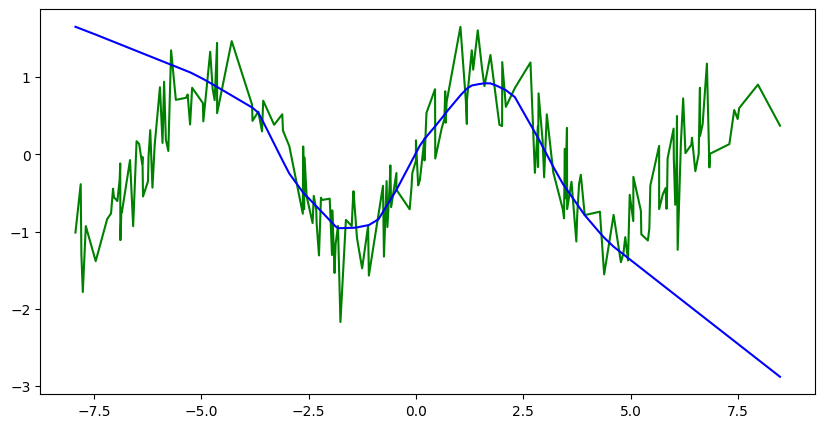

In [6]:
# Sortiere alles nach X_test für saubere Plotlinien
sort_idx = np.argsort(X_test.flatten())

X_test_sorted = X_test[sort_idx]
y_test_sorted = y_test[sort_idx]
mean_map_sorted = mean_map[sort_idx]

plt.figure(figsize=(10,5))
plt.plot(X_test_sorted, y_test_sorted, 'g-', label='True')
plt.plot(X_test_sorted, mean_map_sorted, "b-", label='MAP NN Mean')
plt.show()

In [7]:
# Base + bayesian Last Layer model
base = BaseNetwork(1).to(device)
head = nn.Linear(16,1).to(device)
baseMod = nn.Sequential(base,head)
TrainNN(baseMod,trainLoader,100)
# freezing base weights
for p in baseMod.parameters():
    p.requires_grad = False
lastLayer = BayesianLastLayer(in_features=16,out_features=1, logvals=-0.5,prior_sigma=0.5).to(device)
TrainLastLayer(base,lastLayer,trainLoader,epochs=100)
meanB, stdB = PredLastLayer(base,lastLayer,tenXTest,nSamples=110)

Epoch: 0 | Loss: 0.42719
Epoch: 20 | Loss: 0.14727
Epoch: 40 | Loss: 0.17591
Epoch: 60 | Loss: 0.19106
Epoch: 80 | Loss: 0.14980


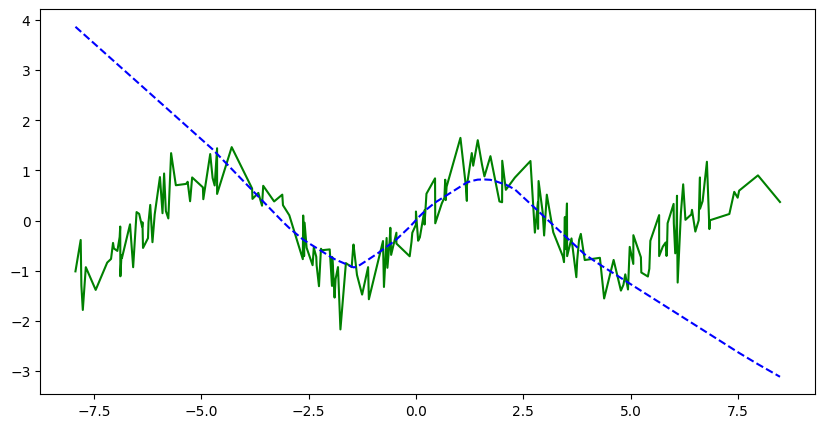

In [8]:
meanB_sorted = meanB[sort_idx]
stdB_sorted = stdB[sort_idx]
plt.figure(figsize=(10,5))
# epistemic uncertainty
plt.plot(X_test_sorted, y_test_sorted, 'g-', label='True')
plt.plot(X_test_sorted, meanB_sorted, 'b--', label='MAP NN Mean')
plt.show()


In [9]:
#
InDist = np.array(InDist)
InDist_sorted = InDist[sort_idx]
OODist = [not x for x in InDist_sorted]

mapUnID = std_map[InDist]
mapUnOOD = std_map[OODist]

bllUnID = stdB[InDist]
bllUnOOD = stdB[OODist]

print(f"MAP NN: In-dist uncertainty = {mapUnID.mean():.4f}, OOD uncertainty = {mapUnOOD.mean():.4f}")
print(f"Bayesian Last Layer: In-dist uncertainty = {bllUnID.mean():.4f}, OOD average std = {bllUnOOD.mean():.4f}")


MAP NN: In-dist uncertainty = 0.0000, OOD uncertainty = 0.0000
Bayesian Last Layer: In-dist uncertainty = 0.8443, OOD average std = 2.1351


In [1]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Plot 1: MAP
ax1.scatter( X_test_sorted, y_test_sorted, alpha=0.3, linewidths=0.01, color="b" )
ax1.plot(    X_test_sorted, mean_map_sorted, 'r-', label='MAP NN Mean' )
ax1.plot(X_test_sorted,np.sin(X_test_sorted), 'k--', )
ax1.fill_between(X_test_sorted.flatten(),
                 mean_map_sorted-2*np.full_like(mean_map, 0.4, dtype=float),
                 mean_map_sorted+2*np.full_like(mean_map, 0.4, dtype=float),
                 alpha=0.2, label='±2σ', color ='tab:orange' )
ax1.axvline(-4, color='k', ls='--')
ax1.axvline( 4, color='k', ls='--')
ax1.legend(loc="upper right", fontsize=8)
ax1.set_title('MAP Prediction vs True')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_yticks(np.arange(-10, 20, 5))
ax1.text(x=6,y=-8,s="OOD")
ax1.text(x=-6,y=-8,s="OOD")
ax1.text(x=0,y=-8,s="ID")
# Plot 2: BayesLL
ax2.scatter( X_test_sorted, y_test_sorted, alpha=0.4, linewidths=0.01, color="b" )
ax2.plot(    X_test_sorted, meanB_sorted, 'r-', label='BayesLL Mean' )
ax2.plot(X_test_sorted,np.sin(X_test_sorted), 'k--', )
ax2.fill_between(X_test_sorted.flatten(),
                 meanB_sorted-2*stdB_sorted,
                 meanB_sorted+2*stdB_sorted,
                 alpha=0.2, label='BayesLL ±2σ', color ='tab:orange' )
ax2.axvline(-4, color='k', ls='--')
ax2.axvline( 4, color='k', ls='--')
ax2.legend(loc="upper right", fontsize=8)
ax2.set_title('BLL Prediction including Predictive Uncertainty')
ax2.set_xlabel('x')
ax2.set_yticks(np.arange(-10, 20, 5))
ax2.text(x=6,y=-8,s="OOD")
ax2.text(x=-6,y=-8,s="OOD")
ax2.text(x=0,y=-8,s="ID")
plt.tight_layout()
plt.savefig("../results/Simulation.png")
plt.show()


NameError: name 'plt' is not defined

Table for ID vs OOD MSE

In [17]:
def rmse(y, m):                     # root-mean-squared error
    return np.sqrt(np.mean((y - m)**2))

def nll(y, m, s):                   # negative log-likelihood (Gaussian)
    return -np.mean(norm.logpdf(y, loc=m, scale=s))

def pi_coverage(y, m, s, z=1.96):   # prediction-interval coverage
    lower = m - z*s
    upper = m + z*s
    return np.mean((y >= lower) & (y <= upper))

def avg_sigma(s):                  # average predictive std dev
    return np.mean(s)

sigma_ID_map  = np.full_like(mean_map[InDist], 0.4, dtype=float)
sigma_OOD_map = np.full_like(mean_map[OODist], 0.4, dtype=float)

rows = []
for name, (mu_id, sig_id, mu_ood, sig_ood) in {
        "MAP": (mean_map[InDist],  sigma_ID_map,  mean_map[OODist],sigma_OOD_map),
        "BLL": (meanB[InDist],  stdB[InDist],  meanB[OODist],  stdB[OODist])
    }.items():

    rows.append({
        "Model": name,
        "Region": "ID",
        "RMSE":  rmse(y_test[InDist],  mu_id),
        "NLL":   nll (y_test[InDist],  mu_id, sig_id),
        "PI cov":pi_coverage(y_test[InDist],  mu_id, sig_id),
        "Avg σ": avg_sigma(sig_id)
    })

    rows.append({
        "Model": name,
        "Region": "OOD",
        "RMSE":  rmse(y_test[InDist], mu_ood),
        "NLL":   nll (y_test[InDist], mu_ood, sig_ood),
        "PI cov":pi_coverage(y_test[OODist], mu_ood, sig_ood),
        "Avg σ": avg_sigma(sig_ood)
    })

results_df = pd.DataFrame(rows)
results_df = results_df[["Model", "Region", "RMSE", "NLL", "PI cov", "Avg σ"]]
results_df


results_df.to_csv("../results/simulation_metrics.csv", index=False)

In [12]:
mse_id_map = mean_squared_error(y_test_sorted[InDist_sorted],mean_map_sorted[InDist_sorted])
mse_ood_map = mean_squared_error(y_test_sorted[OODist],mean_map_sorted[OODist])

bll_id_mse =  mean_squared_error(y_test_sorted[InDist_sorted],meanB_sorted[InDist_sorted])
bll_ood_mse =  mean_squared_error(y_test_sorted[OODist],meanB_sorted[OODist])
print("MSE, MAP vs BNN:\n")
print(f"Map ID:{mse_id_map}")
print(f"Map OOD:{mse_ood_map}")
print(f"BLL ID:{bll_id_mse}")
print(f"BLL OOD:{bll_ood_mse}")


MSE, MAP vs BNN:

Map ID:0.14160938560962677
Map OOD:2.96127986907959
BLL ID:0.15798531472682953
BLL OOD:6.065227031707764
